#Purchase Prediction with AutoML Tables

To use this Colab notebook, copy it to your own Google Drive and open it with [Colaboratory](https://colab.research.google.com/) (or Colab). To run a cell hold the Shift key and press the Enter key (or Return key). Colab automatically displays the return value of the last line in each cell. Refer to [this page](https://colab.sandbox.google.com/notebooks/welcome.ipynb) for more information on Colab.

You can run a Colab notebook on a hosted runtime in the Cloud. The hosted VM times out after 90 minutes of inactivity and you will lose all the data stored in the memory including your authentication data. If your session gets disconnected (for example, because you closed your laptop) for less than the 90 minute inactivity timeout limit, press 'RECONNECT' on the top right corner of your notebook and resume the session. After Colab timeout, you'll need to

1.   Re-run the initialization and authentication.
2.   Continue from where you left off. You may need to copy-paste the value of some variables such as the `dataset_name` from the printed output of the previous cells.

Alternatively you can connect your Colab notebook to a [local runtime](https://research.google.com/colaboratory/local-runtimes.html). 
It is recommended to run this notebook using vm, as the computational complexity is high enough that the hosted runtime becomes inconveniently slow. The local runtime link above also contains instructions for running the notebook on a vm. When using a vm, be sure to use a tensorflow vm, as it comes with the colab libraries. A standard vm of vCPUs will not work with the colab libraries required for this colab.


#1. Project Set Up
Follow the [AutoML Tables documentation](https://cloud.google.com/automl-tables/docs/) to
* Create a Google Cloud Platform (GCP) project.
* Enable billing.
* Apply to whitelist your project.
* Enable AutoML API.
* Enable AutoML Tables API.
* Create a service account, grant required permissions, and download the service account private key.

You also need to upload your data into Google Cloud Storage (GCS) or BigQuery. For example, to use GCS as your data source
* Create a GCS bucket.
* Upload the training and batch prediction files.


**Warning:** Private keys must be kept secret. If you expose your private key it is recommended to revoke it immediately from the Google Cloud Console.
Extra steps, other than permission setting
1. download both the client library and the service account
2. zip up the client library and upload it to the vm
3. upload the service account key to the vm



# 2. Initialize and authenticate
 This section runs intialization and authentication. It creates an authenticated session which is required for running any of the following sections.

### Install the client library
Upload the client library to either your vm or your local machine in the same directory that the notebook is hosted in.

In [0]:
#@title Install AutoML Tables client library { vertical-output: true }
#need to upload the client library file to the vm
import tarfile
name = 'automl-beta-python-20190314 (1).tar.gz'  #@param {type:'string'}
tar = tarfile.open(name, "r:gz")
tar.extractall()
tar.close()
!sudo pip install ./python



### Authenticate using service account key
Create a service account key, and download it onto either your local machine or vm. Write in the path to the service account key. If your Service Account key file or folder is hidden, you can reveal it in a Mac by pressing the <b>Command + Shift + .</b> combo.


In [0]:
#@title Authenticate using service account key and create a client. 
from google.cloud import automl_v1beta1
import os 
path = "my-project-trial5-e542e03e96c7.json" #@param {type:'string'}
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path

# Authenticate and create an AutoML client.
client = automl_v1beta1.AutoMlClient.from_service_account_file(path)
# Authenticate and create a prediction service client.
prediction_client = automl_v1beta1.PredictionServiceClient.from_service_account_file(path)

Enter your GCP project ID.


In [0]:
#@title GCP project ID and location

project_id = 'my-project-trial5' #@param {type:'string'}
location = 'us-central1'
location_path = client.location_path(project_id, location)
location_path



'projects/my-project-trial5/locations/us-central1'

# 3. Import, clean, transform and perform feature engineering on the training Data

### Create dataset in AutoML Tables


Select a dataset display name and pass your table source information to create a new dataset.


In [0]:
#@title Create dataset { vertical-output: true, output-height: 200 }

dataset_display_name = 'colab_trial11' #@param {type: 'string'}

create_dataset_response = client.create_dataset(
    location_path,
    {'display_name': dataset_display_name, 'tables_dataset_metadata': {}})
dataset_name = create_dataset_response.name
create_dataset_response



Create a bucke to store the training data in

In [0]:
#@title Create bucket to store data in { vertical-output: true, output-height: 200 }

bucket_name = 'trial_for_c4m' #@param {type: 'string'}


### Import Dependencies


In [0]:
!sudo pip install google-cloud-bigquery google-cloud-storage pandas pandas-gbq gcsfs oauth2client

import datetime
import pandas as pd

import gcsfs
from google.cloud import bigquery
from google.cloud import storage

### Transformation and Feature Engineering Functions


In [0]:
def balanceTable(table):
	#class count
  count_class_false, count_class_true = table.totalTransactionRevenue.value_counts()

	#divide by class
  table_class_false = table[table["totalTransactionRevenue"] == False]
  table_class_true = table[table["totalTransactionRevenue"] == True]

	#random over-sampling
  table_class_true_over = table_class_true.sample(count_class_false, replace = True)
  table_test_over = pd.concat([table_class_false, table_class_true_over])
  return table_test_over


def partitionTable(table, dt=20170500):
  #the automl tables model could be training on future data and implicitly learning about past data in the testing
  #dataset, this would cause data leakage. To prevent this, we are training only with the first 9 months of data (table1)
  #and doing validation with the last three months of data (table2).
  table1 = table[table["date"] <= dt]
  table2 = table[table["date"] > dt]
  return table1, table2

def N_updatePrevCount(table, new_column, old_column):
  table = table.fillna(0)
  table[new_column] = 1
  table.sort_values(by=['fullVisitorId','date'])
  table[new_column] = table.groupby(['fullVisitorId'])[old_column].apply(lambda x: x.cumsum())
  table.drop([old_column], axis = 1, inplace = True)
  return table


def N_updateDate(table):
  table['weekday'] = 1
  table['date'] = pd.to_datetime(table['date'].astype(str), format = '%Y%m%d')
  table['weekday'] = table['date'].dt.dayofweek
  return table


def change_transaction_values(table):
  table['totalTransactionRevenue'] = table['totalTransactionRevenue'].fillna(0)
  table['totalTransactionRevenue'] = table['totalTransactionRevenue'].apply(lambda x: x!=0)
  return table

def saveTable(table, csv_file_name, bucket_name):
  table.to_csv(csv_file_name, index = False)
  storage_client = storage.Client()
  bucket = storage_client.get_bucket(bucket_name)
  blob = bucket.blob(csv_file_name)
  blob.upload_from_filename(filename = csv_file_name)

###Import training data

You also have the option of just downloading the file, FULL.csv, [here](https://storage.cloud.google.com/cloud-ml-data/automl-tables/notebooks/trial_for_c4m/FULL.csv), instead of running the code below. Just be sure to move the file into the google cloud storage bucket you specified above.

In [0]:
#@title Input name of file to save data to { vertical-output: true, output-height: 200 }
sqll = '''
SELECT
date, device, geoNetwork, totals, trafficSource, fullVisitorId 
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
_TABLE_SUFFIX BETWEEN FORMAT_DATE('%Y%m%d',DATE_SUB('2017-08-01', INTERVAL 366 DAY))
AND
FORMAT_DATE('%Y%m%d',DATE_SUB('2017-08-01', INTERVAL 1 DAY))
'''
df = pd.read_gbq(sqll, project_id = project_id, dialect='standard')
print(df.iloc[:3])
path_to_data_pre_transformation = "FULL.csv" #@param {type: 'string'}
saveTable(df, path_to_data_pre_transformation, bucket_name)



###Unnest the Data

In [0]:
#some transformations on the basic dataset
#@title Input the name of file to hold the unnested data to { vertical-output: true, output-height: 200 }
unnested_file_name = "FULL_unnested.csv" #@param {type: 'string'}


You also have the option of just downloading the file, FULL_unnested.csv, [here](https://storage.cloud.google.com/cloud-ml-data/automl-tables/notebooks/trial_for_c4m/FULL_unnested.csv), instead of running the code below. Just be sure to move the file into the google cloud storage bucket you specified above.

In [0]:

table = pd.read_csv("gs://"+bucket_name+"/"+file_name)

column_names = ['device', 'geoNetwork','totals', 'trafficSource']

for name in column_names:
  print(name)
  table[name] = table[name].apply(lambda i: dict(eval(i)))
  temp = table[name].apply(pd.Series)
  table = pd.concat([table, temp], axis=1).drop(name, axis=1)

#need to drop a column
table.drop(['adwordsClickInfo'], axis = 1, inplace = True)
saveTable(table, unnested_file_name, bucket_name)

###Run the Transformations

In [0]:
table = pd.read_csv("gs://"+bucket_name+"/"+unnested_file_name)

consts = ['transactionRevenue', 'transactions', 'adContent', 'browserSize', 'campaignCode', 
'cityId', 'flashVersion', 'javaEnabled', 'language', 'latitude', 'longitude', 'mobileDeviceBranding', 
'mobileDeviceInfo', 'mobileDeviceMarketingName','mobileDeviceModel','mobileInputSelector', 'networkLocation', 
'operatingSystemVersion', 'screenColors', 'screenResolution', 'screenviews', 'sessionQualityDim', 'timeOnScreen',
'visits', 'uniqueScreenviews', 'browserVersion','referralPath','fullVisitorId', 'date']

table = N_updatePrevCount(table, 'previous_views', 'pageviews')
table = N_updatePrevCount(table, 'previous_hits', 'hits')
table = N_updatePrevCount(table, 'previous_timeOnSite', 'timeOnSite')
table = N_updatePrevCount(table, 'previous_Bounces', 'bounces')

table = change_transaction_values(table)

table1, table2 = partitionTable(table)
table1 = N_updateDate(table1)
table2 = N_updateDate(table2)
#validation_unnested_FULL.csv = the last 3 months of data

table.drop(consts, axis = 1, inplace = True)

saveTable(table2,'validation_unnested_FULL.csv', bucket_name)

table1 = balanceTable(table1)

#training_unnested_FULL.csv = the first 9 months of data
saveTable(table1, 'training_unnested_balanced_FULL.csv', bucket_name)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [0]:
#@title ... take the data source from GCS { vertical-output: true } 

dataset_gcs_input_uris = ['gs://trial_for_c4m/training_unnested_balanced_FULL.csv',] #@param
# Define input configuration.
input_config = {
    'gcs_source': {
        'input_uris': dataset_gcs_input_uris
    }
}

In [0]:
 #@title Import data { vertical-output: true }

import_data_response = client.import_data(dataset_name, input_config)
print('Dataset import operation: {}'.format(import_data_response.operation))
# Wait until import is done.
import_data_result = import_data_response.result()
import_data_result

# 4. Update dataset: assign a label column and enable nullable columns

AutoML Tables automatically detects your data column type. Depending on the type of your label column, AutoML Tables chooses to run a classification or regression model. If your label column contains only numerical values, but they represent categories, change your label column type to categorical by updating your schema.

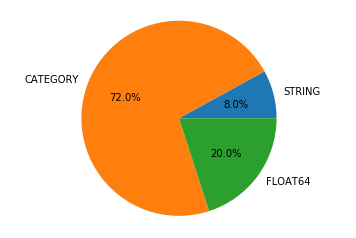

In [0]:
#@title Table schema { vertical-output: true }

import google.cloud.automl_v1beta1.proto.data_types_pb2 as data_types
import matplotlib.pyplot as plt

# List table specs
list_table_specs_response = client.list_table_specs(dataset_name)
table_specs = [s for s in list_table_specs_response]
# List column specs
table_spec_name = table_specs[0].name
list_column_specs_response = client.list_column_specs(table_spec_name)
column_specs = {s.display_name: s for s in list_column_specs_response}
# Table schema pie chart.
type_counts = {}
for column_spec in column_specs.values():
  type_name = data_types.TypeCode.Name(column_spec.data_type.type_code)
  type_counts[type_name] = type_counts.get(type_name, 0) + 1

plt.pie(x=type_counts.values(), labels=type_counts.keys(), autopct='%1.1f%%')
plt.axis('equal')
plt.show()


In [0]:
#@title Update a column: set to not nullable { vertical-output: true }

update_column_spec_dict = {
    'name': column_specs['totalTransactionRevenue'].name,
    'data_type': {
        'type_code': 'CATEGORY',
        'nullable': False
    }
}
update_column_response = client.update_column_spec(update_column_spec_dict)
update_column_response

**Tip:** You can use `'type_code': 'CATEGORY'` in the preceding `update_column_spec_dict` to convert the column data type from `FLOAT64` `to `CATEGORY`.




### Update dataset: assign a label

In [0]:
#@title Update dataset { vertical-output: true }

label_column_name = 'totalTransactionRevenue' #@param {type: 'string'}
label_column_spec = column_specs[label_column_name]
label_column_id = label_column_spec.name.rsplit('/', 1)[-1]
print('Label column ID: {}'.format(label_column_id))
# Define the values of the fields to be updated.
update_dataset_dict = {
    'name': dataset_name,
    'tables_dataset_metadata': {
        'target_column_spec_id': label_column_id
    }
}
update_dataset_response = client.update_dataset(update_dataset_dict)
update_dataset_response

#5. Creating a model

### Train a model
Training the model may take one hour or more. The following cell keeps running until the training is done. If your Colab times out, use `client.list_models(location_path)` to check whether your model has been created. Then use model name to continue to the next steps. Run the following command to retrieve your model. Replace `model_name` with its actual value.

    model = client.get_model(model_name)
  

In [0]:
#@title Create model { vertical-output: true }
#this will create a model that can be access through the auto ml tables colab
model_display_name = 'trial_10' #@param {type:'string'}

model_dict = {
    'display_name': model_display_name,
    'dataset_id': dataset_name.rsplit('/', 1)[-1],
    'tables_model_metadata': {'train_budget_milli_node_hours': 1000}
}
create_model_response = client.create_model(location_path, model_dict)
print('Dataset import operation: {}'.format(create_model_response.operation))
# Wait until model training is done.
create_model_result = create_model_response.result()
model_name = create_model_result.name
print(model_name)

# 6. Make a prediction

There are two different prediction modes: online and batch. The following cell shows you how to make a batch prediction.

In [0]:
#@title Start batch prediction { vertical-output: true, output-height: 200 }
print(client.list_models(location_path))

batch_predict_gcs_input_uris = ['gs://trial_for_c4m/validation_unnested_FULL.csv',] #@param
batch_predict_gcs_output_uri_prefix = 'gs://trial_for_c4m' #@param {type:'string'}
# Define input source.
batch_prediction_input_source = {
  'gcs_source': {
    'input_uris': batch_predict_gcs_input_uris
  }
}
# Define output target.
batch_prediction_output_target = {
    'gcs_destination': {
      'output_uri_prefix': batch_predict_gcs_output_uri_prefix
    }
}
batch_predict_response = prediction_client.batch_predict(
    model_name, batch_prediction_input_source, batch_prediction_output_target)
print('Batch prediction operation: {}'.format(batch_predict_response.operation))
# Wait until batch prediction is done.
batch_predict_result = batch_predict_response.result()
batch_predict_response.metadata



#7. Evaluate your prediction

The follow cell creates a Precision Recall Curve and a ROC curve for both the true and false classifications.
Fill in the batch_predict_results_location with the location of the results.csv file created in the previous "Make a prediction" step


In [0]:

import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

def invert(x):
  return 1-x

def switch_label(x):
  return(not x)
batch_predict_results_location = 'gs://trial_for_c4m/prediction-trial_10-2019-03-23T00:22:56.802Z' #@param {type:'string'}

table = pd.read_csv(batch_predict_results_location +'/result.csv')
y = table["totalTransactionRevenue"]
scores = table["totalTransactionRevenue_1.0_score"]
scores_invert = table['totalTransactionRevenue_0.0_score']

#code for ROC curve, for true values
fpr, tpr, thresholds = metrics.roc_curve(y, scores)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for True')
plt.legend(loc="lower right")
plt.show()


#code for ROC curve, for false values
plt.figure()
lw = 2
label_invert = y.apply(switch_label)
fpr, tpr, thresholds = metrics.roc_curve(label_invert, scores_invert)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for False')
plt.legend(loc="lower right")
plt.show()


#code for PR curve, for true values

precision, recall, thresholds = metrics.precision_recall_curve(y, scores)


plt.figure()
lw = 2
plt.plot( recall, precision, color='darkorange',
         lw=lw, label='Precision recall curve for True')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve for True')
plt.legend(loc="lower right")
plt.show()

#code for PR curve, for false values

precision, recall, thresholds = metrics.precision_recall_curve(label_invert, scores_invert)
print(precision.shape)
print(recall.shape)

plt.figure()
lw = 2
plt.plot( recall, precision, color='darkorange',
          label='Precision recall curve for False')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve for False')
plt.legend(loc="lower right")
plt.show()

